**Loading dataset using tf.dataset input pipeline and cleaning the data**


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [3]:
Image_size=256
Batch_size=32

#Loading Data

In [4]:
dir='/content/drive/MyDrive/potato-dataset.zip (Unzipped Files)/potato-dataset'
data=tf.keras.preprocessing.image_dataset_from_directory(
    dir,
    shuffle=True,
    image_size=(Image_size,Image_size),
    batch_size=Batch_size
)

Found 2157 files belonging to 3 classes.


In [5]:
#3_classes of data
class_names=data.class_names
print(class_names)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [6]:
#length of the dataset
length=len(data)
print(length)  #68*32=2156(which is approx equal to dataset)

68


#Explore the batch size

In [7]:
for image_batch, label in data.take(1):
  print(image_batch[0].numpy())
  print(label.numpy())

[[[190. 194. 206.]
  [191. 195. 207.]
  [194. 198. 210.]
  ...
  [137. 139. 152.]
  [123. 125. 138.]
  [117. 119. 132.]]

 [[195. 199. 211.]
  [189. 193. 205.]
  [188. 192. 204.]
  ...
  [132. 134. 147.]
  [124. 126. 139.]
  [133. 135. 148.]]

 [[207. 211. 223.]
  [193. 197. 209.]
  [190. 194. 206.]
  ...
  [136. 138. 151.]
  [131. 133. 146.]
  [135. 137. 150.]]

 ...

 [[169. 171. 183.]
  [166. 168. 180.]
  [163. 165. 177.]
  ...
  [130. 127. 138.]
  [133. 130. 141.]
  [140. 137. 148.]]

 [[160. 162. 174.]
  [155. 157. 169.]
  [151. 153. 165.]
  ...
  [147. 144. 155.]
  [145. 142. 153.]
  [144. 141. 152.]]

 [[170. 172. 184.]
  [165. 167. 179.]
  [161. 163. 175.]
  ...
  [132. 129. 140.]
  [124. 121. 132.]
  [118. 115. 126.]]]
[0 1 0 0 2 1 0 1 0 1 0 0 1 1 1 0 1 0 1 0 0 2 1 0 1 0 0 1 1 0 0 1]


#Visualize the images

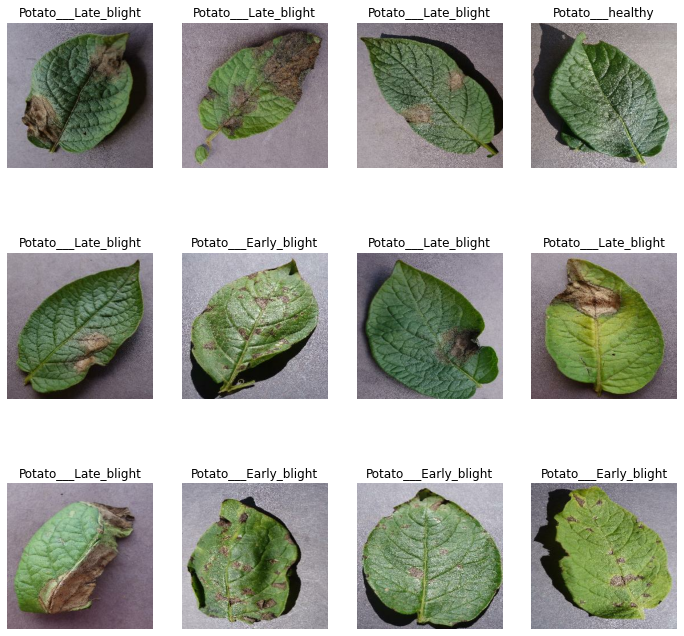

In [8]:
plt.figure(figsize=(12,12))
for image_batch,label in data.take(1):
  for i in range(12):
    ax=plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names[label[i]])
    plt.axis("off")

#Split the dataset


*   80% --> training
*   20% --> testing   (10% --> validation, 10% --> tesing)








In [9]:
def get_splitted_dataset(data,train_split=0.8,test_split=0.1,val_split=0.1,shuffle=True,shuffle_size=10000):
  data_length=len(data)
  if shuffle:
    data=data.shuffle(shuffle_size,seed=12)
  train_size=int(train_split*data_length)
  val_size=int(val_split*data_length)

  train_data=data.take(train_size)
  val_data=data.skip(train_size).take(val_size)
  test_data=data.skip(train_size).skip(val_size)

  return train_data, test_data, val_data

In [10]:
train_data, test_data, val_data= get_splitted_dataset(data)

In [11]:
print(len(train_data))
print(len(test_data))
print(len(val_data))

54
8
6


#code that should not keep cpu or gpu idle

In [12]:
train_data=train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data=test_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data=val_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

#Image Preprocessing

In [13]:
resize_and_rescale=tf.keras.Sequential([
              layers.experimental.preprocessing.Resizing(Image_size,Image_size),
              layers.experimental.preprocessing.Rescaling(1.0/255)
])

#Data-Augmentation

In [14]:
data_augmentation=tf.keras.Sequential([
                       layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                       layers.experimental.preprocessing.RandomRotation(0.2)                
])

#Model_Building using CNN

In [15]:
channel=3
input_shape=(Batch_size,Image_size,Image_size,channel)
model=models.Sequential([
                         resize_and_rescale,
                         data_augmentation,
                         #first cnn layer
                         layers.Conv2D(32,(3,3), activation="relu", kernel_initializer="he_uniform", input_shape=input_shape),
                         layers.MaxPooling2D((2,2)),
                         #second cnn layer
                         layers.Conv2D(64,(3,3),activation="relu",kernel_initializer="he_uniform"),
                         layers.MaxPooling2D((2,2)),
                         #third cnn layer
                         layers.Conv2D(64,(3,3),activation="relu",kernel_initializer="he_uniform"),
                         layers.MaxPooling2D((2,2)),
                         #forth cnn layer
                         layers.Conv2D(64,(3,3),activation="relu",kernel_initializer="he_uniform"),
                         layers.MaxPooling2D((2,2)),
                         #fifth cnn layer
                         layers.Conv2D(64,(3,3),activation="relu",kernel_initializer="he_uniform"),
                         layers.MaxPooling2D((2,2)),
                         #sixth cnn layer
                         layers.Conv2D(64,(3,3),activation="relu",kernel_initializer="he_uniform"),
                         layers.MaxPooling2D((2,2)),
                         #flatten layer
                         layers.Flatten(),
                         #first Dense layer
                         layers.Dense(units=64, activation="relu", kernel_initializer="he_uniform"),
                         #output layer
                         layers.Dense(3, activation="softmax")
])
model.build(input_shape=input_shape)

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)         

In [17]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [18]:
model.fit(train_data,
          epochs=40,
          batch_size=Batch_size,
          validation_data=val_data,
          verbose=1)

Epoch 1/40
54/54 [==============================] - 229s 225ms/step - loss: 0.8679 - accuracy: 0.5590 - val_loss: 0.6972 - val_accuracy: 0.6250
Epoch 2/40
54/54 [==============================] - 6s 120ms/step - loss: 0.5404 - accuracy: 0.7639 - val_loss: 0.3296 - val_accuracy: 0.8854
Epoch 3/40
54/54 [==============================] - 6s 119ms/step - loss: 0.2480 - accuracy: 0.9034 - val_loss: 0.3046 - val_accuracy: 0.8750
Epoch 4/40
54/54 [==============================] - 6s 119ms/step - loss: 0.2188 - accuracy: 0.9178 - val_loss: 0.1467 - val_accuracy: 0.9375
Epoch 5/40
54/54 [==============================] - 6s 119ms/step - loss: 0.1776 - accuracy: 0.9236 - val_loss: 0.1796 - val_accuracy: 0.9167
Epoch 6/40
54/54 [==============================] - 6s 119ms/step - loss: 0.1394 - accuracy: 0.9444 - val_loss: 0.1419 - val_accuracy: 0.9427
Epoch 7/40
54/54 [==============================] - 6s 119ms/step - loss: 0.1043 - accuracy: 0.9583 - val_loss: 0.0931 - val_accuracy: 0.9688
Epoc

In [19]:
score=model.evaluate(test_data)

8/8 [==============================] - 5s 40ms/step - loss: 0.0158 - accuracy: 0.9961


#Prediction

showing first_image
actual_label Potato___Late_blight
predicted_label Potato___Late_blight


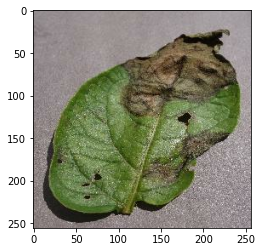

In [22]:
for image_batch, label in test_data.take(1):
  img1=image_batch[0].numpy().astype('uint8')
  label1=label[0].numpy()
  print("showing first_image")
  plt.imshow(img1)
  print("actual_label",class_names[label1])

  batch_prediction=model.predict(image_batch)
  print("predicted_label",class_names[np.argmax(batch_prediction[0])])

In [23]:
def predict(model,img):
  img_array= tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array= tf.expand_dims(img_array,0)#create a batch
  predictions=model.predict(img_array)
  predicted_class=class_names[np.argmax(batch_prediction[0])]
  confidence=round(100 * (np.argmax(predictions[0])),2)
  return predicted_class, confidence

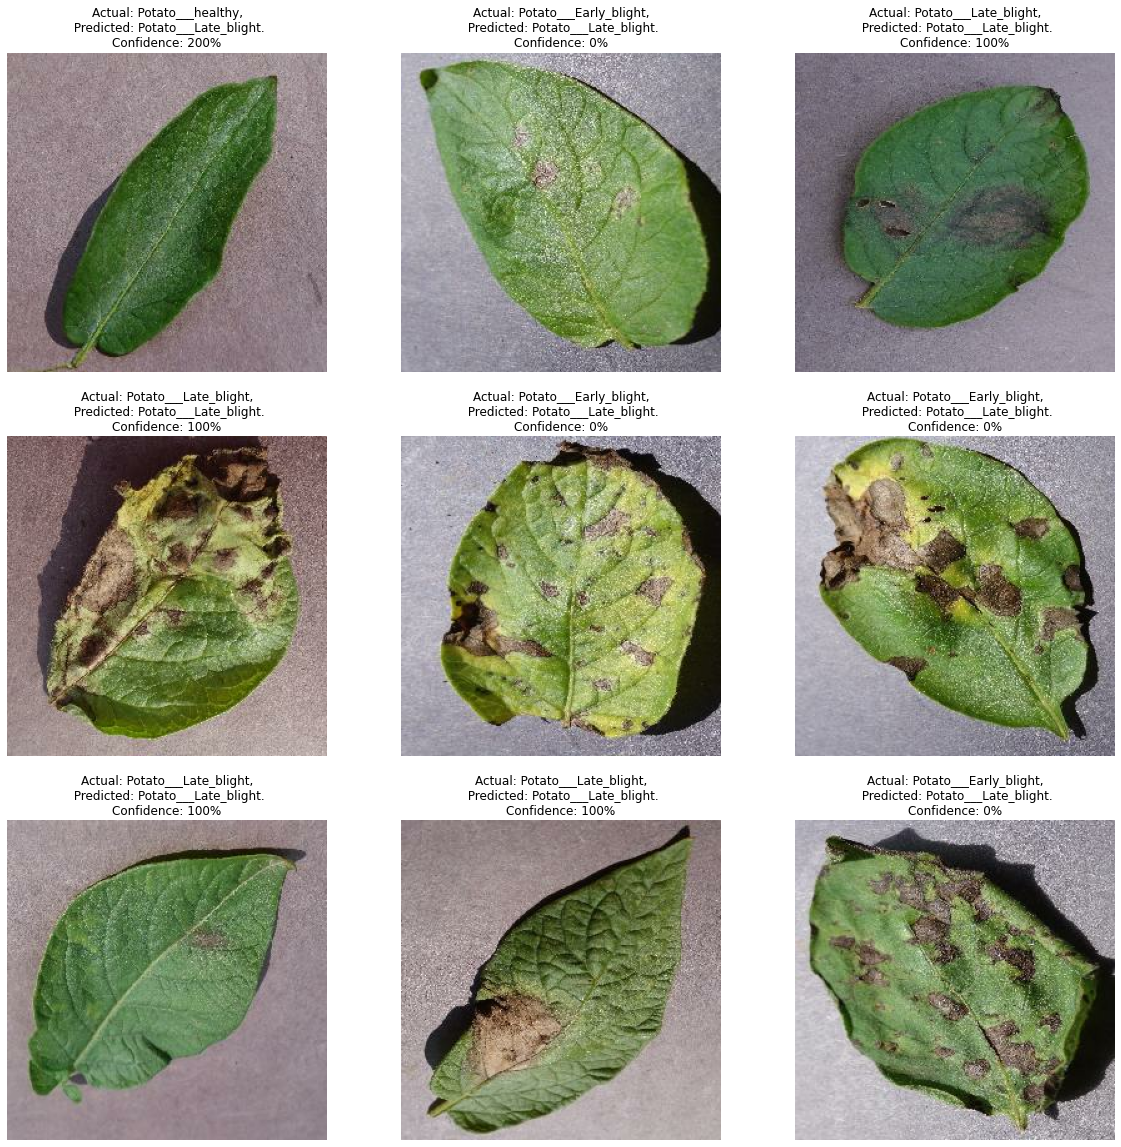

In [25]:
plt.figure(figsize=(20,20))
for images,labels in test_data.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    predicted_class,confidence=predict(model, images[i].numpy())
    actual_class= class_names[labels[i]]
    plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\nConfidence: {confidence}%")
    plt.axis('off')

In [27]:
model.save("/content/drive/MyDrive/model/potato_model")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/model/potato_model/assets
